In [10]:
import os
from modelzipper.tutils import *
import datasets
import torch
import copy
import numpy as np
import transformers
import matplotlib.pyplot as plt
from loguru import logger
import sys
sys.path.append("/data/zecheng/acl2025/MyRLHF/inference")
from utils.babilong.prompts import DEFAULT_PROMPTS, DEFAULT_TEMPLATE, get_formatted_input
sys.path.append("/data/zecheng/acl2025/MyRLHF/build_data/long_context_data")
from pipeline_sg import preprocess_item
sys.path.append("/data/zecheng/acl2025/MyRLHF/evaluation/babilong")
from eval import compare_answers, TASK_LABELS

os.environ["CUDA_VISIBLE_DEVICES"] = "7"

model_name = '/data/zecheng/hf_models/Meta-Llama-3.1-8B-Instruct'
model = transformers.AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16, device_map="balanced_low_0")
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

logger.info('begin to load datasets')
# with open("test_sample.pkl", "rb") as f:
#     test_case = pickle.load(f)
# test_case = content[0][0]['content']  # DEBUG
data = auto_read_data("/data/zecheng/Long-form-reasoning-data/data/generated_tasks/qa3/4k.json")
test_case = data[0]
test_case['task'] = 'qa3'

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it]
2024-11-28 13:32:26.403 | INFO     | __main__:<module>:24 - begin to load datasets


begin to read data from /data/zecheng/Long-form-reasoning-data/data/generated_tasks/qa3/4k.json | file size: 1.5 MB | file type: json


In [2]:
test_case

{'input': '\'There was not a\nsingle man to receive the famous President of the _Provisional\nGovernment_; and it was only after a full hour\'s search, and much\ntrouble, [that] the guide returned with five or six men to land the\narms.\' On the morning of November 4 the party arrived at Napierville. Here Hindenlang found Dr Cote already at the head of two or three\nhundred men. A crowd speedily gathered, and Robert Nelson was\nproclaimed \'President of the Republic of {121} Lower Canada.\' Hindenlang and Touvrey were presented to the crowd; and to his great\nastonishment Hindenlang was informed that his rank in the rebel force\nwas that of brigadier-general. The first two or three days were spent in hastening the arrival of\nreinforcements and in gathering arms. By the 7th Nelson had collected\na force of about twenty-five hundred men, whom Hindenlang told off in\ncompanies and divisions. Most of the rebels were armed with pitchforks\nand pikes. An attempt had been made two days earli

In [11]:
for i, item in enumerate(data):
    item['task'] = 'qa3'
    golden_input_text, model_pred_text, golden_input_ids, pred_input_ids, natural_input_ids, golden_question_pos, pred_question_pos, golden_answer_pos, pred_answer_pos, golden_offset_mapping, pred_offset_mapping, reference_pos, natural_text_reference_pos, res = preprocess_item(item, model, tokenizer, model.device)
    logger.info(res)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


2024-11-28 13:32:28.659 | INFO     | pipeline_sg:preprocess_item:312 - --------------------
2024-11-28 13:32:28.660 | INFO     | pipeline_sg:preprocess_item:313 - question: Where was the football before the bathroom? 
2024-11-28 13:32:28.661 | INFO     | pipeline_sg:preprocess_item:314 - golden: office
2024-11-28 13:32:28.662 | INFO     | pipeline_sg:preprocess_item:315 - model pred: Before the bathroom the football was in the office.
2024-11-28 13:32:28.662 | INFO     | pipeline_sg:preprocess_item:316 - --------------------
2024-11-28 13:32:29.068 | INFO     | __main__:<module>:4 - True
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
2024-11-28 13:32:29.835 | INFO     | pipeline_sg:preprocess_item:312 - --------------------
2024-11-28 13:32:29.836 | INFO     | pipeline_sg:preprocess_ite

KeyboardInterrupt: 

: 

In [3]:
golden_input_text, model_pred_text, golden_input_ids, pred_input_ids, natural_input_ids, golden_question_pos, pred_question_pos, golden_answer_pos, pred_answer_pos, golden_offset_mapping, pred_offset_mapping, reference_pos, natural_text_reference_pos, res = preprocess_item(test_case, model, tokenizer, model.device)
print(golden_input_ids.shape)
torch.cuda.empty_cache()

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
2024-11-28 13:18:00.024 | INFO     | pipeline_sg:preprocess_item:312 - --------------------
2024-11-28 13:18:00.026 | INFO     | pipeline_sg:preprocess_item:313 - question: Where was the football before the bathroom? 
2024-11-28 13:18:00.027 | INFO     | pipeline_sg:preprocess_item:314 - golden: office
2024-11-28 13:18:00.028 | INFO     | pipeline_sg:preprocess_item:315 - model pred: Before the bathroom Mary dropped the football.
2024-11-28 13:18:00.028 | INFO     | pipeline_sg:preprocess_item:316 - ----------------

torch.Size([1, 31856])


AttributeError: 'list' object has no attribute 'shape'

In [32]:
def viz(loss, chunk_pos, anno_pos=None):
    token_seq = []
    id_dict = {}
    cnt = 0
    for start, end in chunk_pos:
        token_seq.extend(range(start, end))
        for value in range(start, end):
            id_dict[value] = cnt
            cnt += 1

    # 创建图形
    plt.figure(figsize=(10, 6))

    # 绘制整个 loss 序列
    plt.plot(range(len(loss)), loss.numpy(), label='Loss per Token', color='blue')
    
    # 绘制每个区间的 loss，区间为 token_seq 中的索引
    if anno_pos:
        anno_re_ids = []
        for start, end in anno_pos:
            for i in range(start, end):
                anno_re_ids.append(id_dict[i])
        plt.plot(anno_re_ids, loss[anno_re_ids], marker='o', linestyle='--', color='red', label='Loss of Reference Chunks')

    # 添加图形标签
    plt.xlabel('Token Index')
    plt.ylabel('Loss Value')
    plt.title('Loss per Token with Continuous Chunk Highlighted')
    plt.legend()

    # 显示图形
    plt.show()

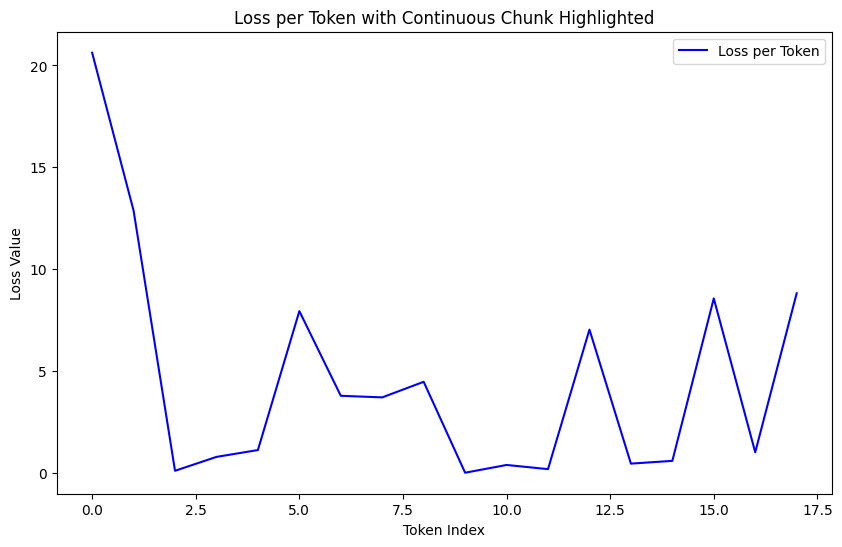

In [35]:
# without question intervention
trunc_len=4096
sliding_window=1024
theta = 2.0
expand_size = 20

with torch.no_grad():
    loss_f = torch.nn.CrossEntropyLoss(reduction='none')
    output_full = model(golden_input_ids)
    loss_overall = loss_f(output_full.logits[0, :-1, :], golden_input_ids[0, 1:]).to(torch.float).cpu().numpy()
    ppl_full = np.exp(loss_overall.mean())

    _, max_len = golden_input_ids.shape
    key_tokens = []
    chunk_score = dict()

    chunk_num = int(np.ceil((max_len - trunc_len)) / sliding_window)
    question_ipt_ids = golden_input_ids[:, golden_question_pos[0]: golden_question_pos[1]]
    question_length = question_ipt_ids.size(1)

    # testing inference with reference chunks
    all_sub_chunks, referece_loss, chunk_pos, key_ref_pos = [], [], [], []
    for ref_pos in reference_pos:
        all_sub_chunks.append(golden_input_ids[:, ref_pos[0]: ref_pos[1]])
        referece_loss.append(loss_overall[ref_pos[0]-expand_size: ref_pos[1]+expand_size])
        chunk_pos.append((ref_pos[0]-expand_size, ref_pos[1]+expand_size))
        key_ref_pos.append((ref_pos[0], ref_pos[1]))
    
    reference_input_ids = torch.cat(all_sub_chunks, dim=1)
    loss_full = torch.tensor(np.concatenate(referece_loss, axis=0))[1:]

    torch.cuda.empty_cache()
    # combined_ref_ipt_ids = torch.cat([question_ipt_ids, reference_input_ids], dim=1)
    output_ref = model(reference_input_ids)
    loss_ref = loss_f(output_ref.logits[0, :-1, :], reference_input_ids[0, 1:]).to(torch.float).cpu()
    # loss_ref = loss_f(output_ref.logits[0, question_length:-1, :], reference_input_ids[0, 1:]).to(torch.float).cpu()
    viz(loss_ref, [(0, loss_ref.size(-1))])

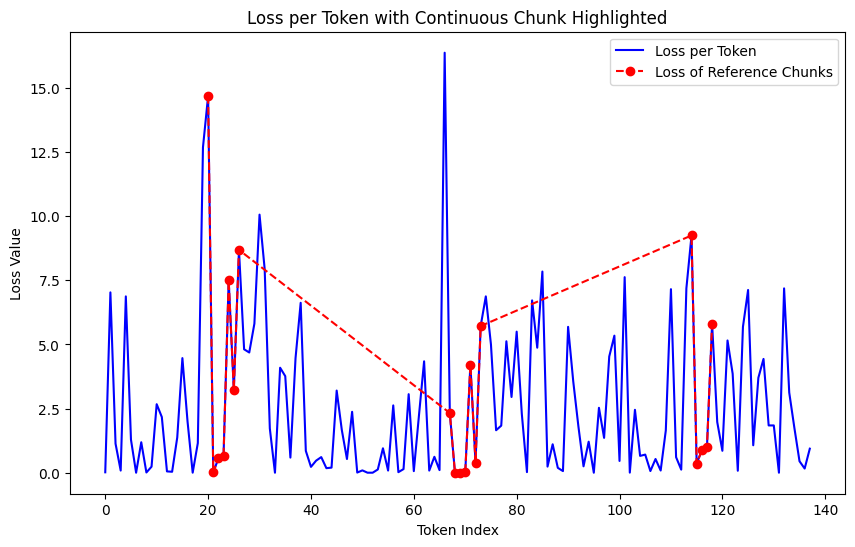

In [ ]:
# with question intervention
trunc_len=4096
sliding_window=1024
theta = 2.0
expand_size = 20

with torch.no_grad():
    loss_f = torch.nn.CrossEntropyLoss(reduction='none')
    output_full = model(golden_input_ids)
    loss_overall = loss_f(output_full.logits[0, :-1, :], golden_input_ids[0, 1:]).to(torch.float).cpu().numpy()
    ppl_full = np.exp(loss_overall.mean())

    _, max_len = golden_input_ids.shape
    key_tokens = []
    chunk_score = dict()

    chunk_num = int(np.ceil((max_len - trunc_len)) / sliding_window)
    question_ipt_ids = golden_input_ids[:, golden_question_pos[0]: golden_question_pos[1]]
    question_length = question_ipt_ids.size(1)

    # testing inference with reference chunks
    all_sub_chunks, referece_loss, chunk_pos, key_ref_pos = [], [], [], []
    for ref_pos in reference_pos:
        all_sub_chunks.append(golden_input_ids[:, ref_pos[0]: ref_pos[1]])
        referece_loss.append(loss_overall[ref_pos[0]-expand_size: ref_pos[1]+expand_size])
        chunk_pos.append((ref_pos[0]-expand_size, ref_pos[1]+expand_size))
        key_ref_pos.append((ref_pos[0], ref_pos[1]))
    
    reference_input_ids = torch.cat(all_sub_chunks, dim=1)
    loss_full = torch.tensor(np.concatenate(referece_loss, axis=0))[1:]

    torch.cuda.empty_cache()
    combined_ref_ipt_ids = torch.cat([question_ipt_ids, reference_input_ids], dim=1)
    output_ref = model(combined_ref_ipt_ids)

    loss_ref = loss_f(output_ref.logits[0, question_length:-1, :], reference_input_ids[0, 1:]).to(torch.float).cpu()
    viz(loss_full, chunk_pos, key_ref_pos)
    # loss_discrepancy = (torch.logical_and(torch.abs(loss_ref - loss_full) > theta, loss_full < theta)).squeeze()

In [5]:
loss_full

tensor([2.6719e+00, 2.1719e+00, 5.2002e-02, 3.7598e-02, 1.3750e+00, 4.4688e+00,
        2.0000e+00, 2.3804e-03, 1.1562e+00, 1.2688e+01, 1.4688e+01, 1.5320e-02,
        5.5469e-01, 6.5234e-01, 7.5000e+00, 3.2344e+00, 8.6875e+00, 4.8125e+00,
        4.6875e+00, 5.8125e+00, 1.0062e+01, 7.9375e+00, 1.7266e+00, 2.0695e-04,
        4.0938e+00, 3.7656e+00, 2.6250e+00, 2.1973e-02, 1.4160e-01, 3.0625e+00,
        6.2256e-02, 2.2344e+00, 4.3438e+00, 8.3008e-02, 6.2109e-01, 1.0156e-01,
        1.6375e+01, 2.3281e+00, 3.6049e-04, 6.2561e-03, 9.5215e-03, 4.2188e+00,
        3.8672e-01, 5.7188e+00, 6.8750e+00, 5.0000e+00, 1.6562e+00, 1.8359e+00,
        5.1250e+00, 2.9531e+00, 5.5000e+00, 2.2969e+00, 2.3682e-02, 2.4531e+00,
        6.5625e-01, 7.0703e-01, 6.5430e-02, 5.3516e-01, 8.5938e-02, 1.6484e+00,
        7.1562e+00, 6.0547e-01, 1.2061e-01, 7.1875e+00, 9.2500e+00, 3.5742e-01,
        8.6719e-01, 9.8438e-01, 5.8125e+00, 1.9766e+00, 8.5547e-01, 5.1562e+00,
        3.8594e+00, 7.7148e-02, 5.6875e+

In [8]:
chunk_pos

[(3062, 3089), (20142, 20169), (24123, 24148)]

In [17]:
key_ref_pos

[(3072, 3079), (20152, 20159), (24133, 24138)]

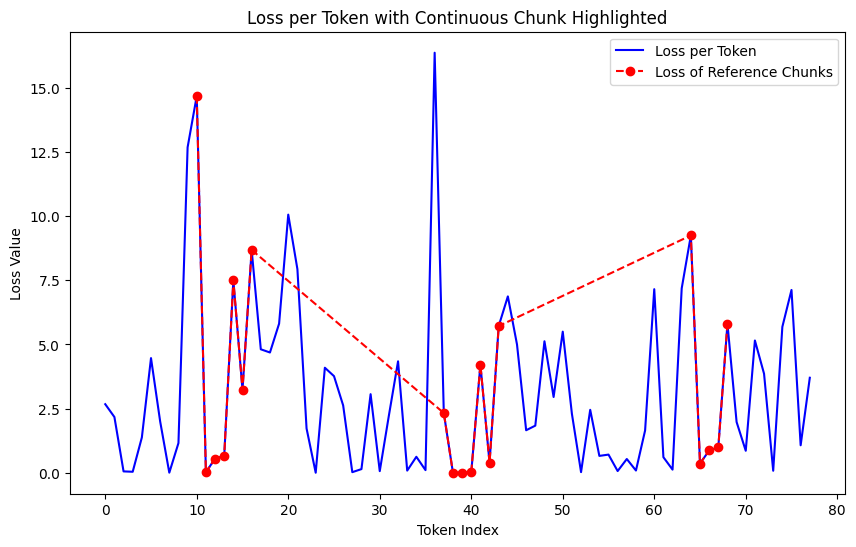